# Contexte

Nous avons un dataset contenant des informations sur les courses de championnat du monde de Formule 1 entre 1950 et 2024, et les données sont réparties dans plusieurs fichiers CSV.

Notre objectif final serait de trouver un ou plusieurs modèles de prédiction pour prédire le classement final d'un constructeur sur une course en fonction de certains paramètres.

In [544]:
# Gestion de tous les imports
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import joblib


# Première analyse des données - Sélection des fichiers nécessaires
Après analyse des fichiers, nous avons besoin seulements des fichiers suivants :
- results
- races
- circuits
- constructors  
- (+ drivers possible)

In [545]:
results = pd.read_csv('data/results.csv')
results.set_index('resultId', inplace=True)

In [546]:
races = pd.read_csv('data/races.csv')
races.set_index('raceId', inplace=True)

In [547]:
circuits = pd.read_csv('data/circuits.csv')
circuits.set_index('circuitId', inplace=True)

In [548]:
constructors = pd.read_csv('data/constructors.csv')
constructors.set_index('constructorId', inplace=True)

In [549]:
results.head() # les colonnes qui semble intéressantes : raceId, constructorId, grid, positionOrder + (driverId ?)

,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
resultId,,,,,,,,,,,,,,,,,
1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [550]:
races.head() # les colonnes qui semble intéressantes : circuitId (la "date" aussi mais pas pour le moment)

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
raceId,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [551]:
circuits.head() # les colonnes qui semble intéressantes : circuitRef

,circuitRef,name,location,country,lat,lng,alt,url
circuitId,,,,,,,,
1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [552]:
constructors.head() # les colonnes qui semble intéressantes : constructorRef

,constructorRef,name,nationality,url
constructorId,,,,
1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [553]:
global_df = pd.merge(results, races, on='raceId')
global_df = pd.merge(global_df, circuits, on='circuitId')
global_df = pd.merge(global_df, constructors, on='constructorId')
global_df.head()

,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,...,location,country,lat,lng,alt,url_y,constructorRef,name,nationality,url
0,18,1,1,22,1,1,1,1,10.0,58,...,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,18,5,1,23,3,5,5,5,4.0,58,...,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,36,4,1,1,2,2,2,2,8.0,58,...,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
3,36,1,1,2,4,3,3,3,6.0,58,...,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
4,55,8,1,3,4,2,2,2,8.0,57,...,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren


In [554]:
global_df.shape

(26519, 46)

# Première analyse des données
Il y a beaucoup de données, il faut donc faire un trie et les nettoyer pour ne garder que les informations nécessaires.

On commence simplement par regarder les informations sur les constructeurs, ainsi nous garderons seulement les constructeurs qui ont assez d'information pour être analysés.

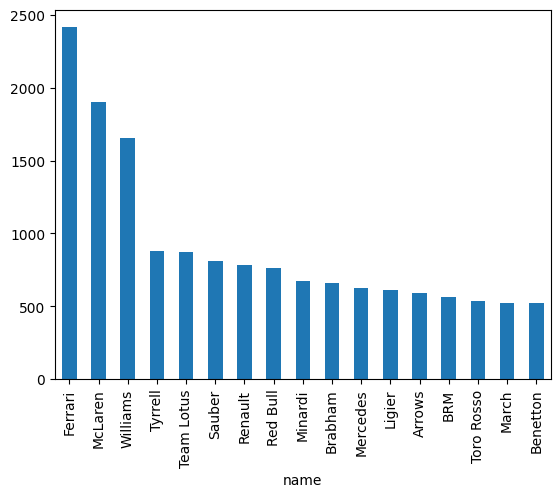

In [555]:
# Nombre de fois qu'un constructeur apparait plus de 500 fois dans les données (la valeur 500 est arbitraire pour ainsi avoir un nombre de constructeurs raisonnable)
global_df['name'].value_counts()[global_df['name'].value_counts() > 500].plot(kind='bar')
plt.show()

De base, nous étions parti sur la liste qui suit, mais après analyse, nous avons décidé de ne garder que les constructeurs ayant au moins 500 lignes de données.

```python
team_names = ["Red Bull", "Mercedes", "Ferrari", "McLaren", "Alpine F1 Team", "Aston Martin", "Haas F1 Team", "Alfa Romeo", "AlphaTauri", "Williams"]
```

Liste finale des constructeurs gardés :

```python
team_names = ["Ferrari", "McLaren", "Williams", "Tyrrell", "Team Lotus", "Sauber", "Renault", "Red Bull", "Minardi", "Brabham", "Mercedes", "Ligier", "Arrows", "BRM", "Toro Rosso", "March", "Benetton"]
```

# Premier traitement des données - Réduction des données avec la liste de constructeurs de F1

In [556]:
# Liste des écuries pour récupérer les constructorRefs
constructor_refs = constructors['constructorRef'].tolist()

team_names = ["Ferrari", "McLaren", "Williams", "Tyrrell", "Team Lotus", "Sauber", "Renault", "Red Bull",
              "Minardi", "Brabham", "Mercedes", "Ligier", "Arrows", "BRM", "Toro Rosso", "March", "Benetton"]

def get_constructor_refs(team_names):
    constructor_refs = {}
    for team_name in team_names:
        result = constructors[constructors['name'].str.contains(team_name, case=False, na=False)]
        if not result.empty:
            constructor_refs[team_name] = result['constructorRef'].values[0]
        else:
            constructor_refs[team_name] = None
    return constructor_refs

constructor_refs = get_constructor_refs(team_names)

print(constructor_refs)

{'Ferrari': 'ferrari', 'McLaren': 'mclaren', 'Williams': 'williams', 'Tyrrell': 'tyrrell', 'Team Lotus': 'team_lotus', 'Sauber': 'bmw_sauber', 'Renault': 'renault', 'Red Bull': 'red_bull', 'Minardi': 'minardi', 'Brabham': 'brabham', 'Mercedes': 'mercedes', 'Ligier': 'ligier', 'Arrows': 'arrows', 'BRM': 'brm', 'Toro Rosso': 'toro_rosso', 'March': 'march', 'Benetton': 'benetton'}


In [557]:
df_selected_ecuries = global_df[global_df['name'].isin(constructor_refs.values().mapping)]
df_selected_ecuries.shape

(15387, 46)

In [558]:
df_selected_ecuries.to_csv('df_selected_ecuries.csv')

# Seconde analyse des données

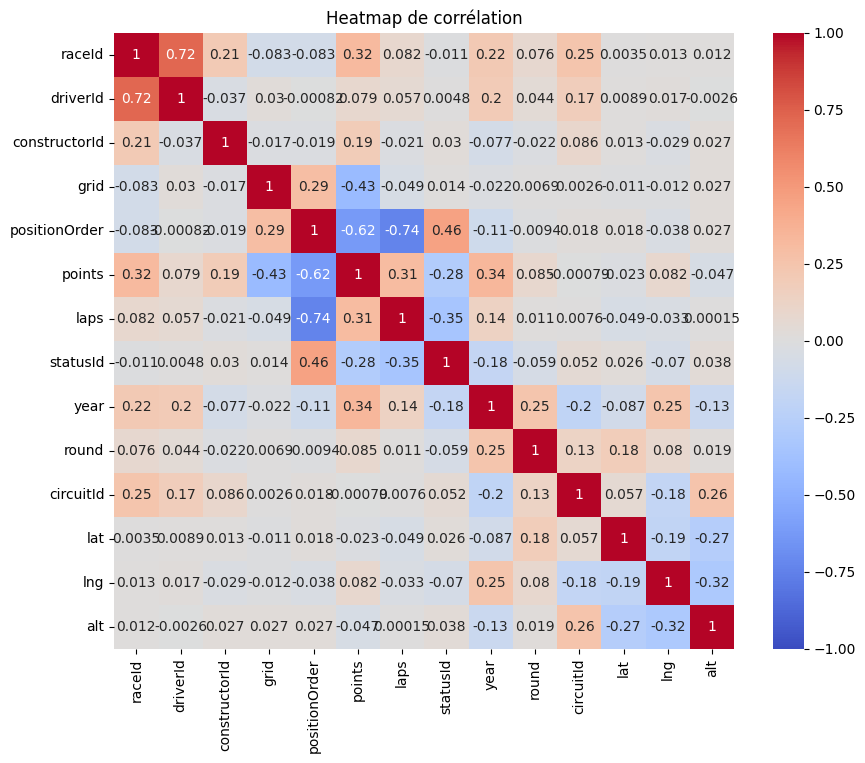

In [559]:
# Réalisation d'une heatmap de corrélation sur les données numériques
df_numeric = df_selected_ecuries.select_dtypes(include=['float64', 'int64'])

# Ajout de la colonne cible 'positionOrder' si elle n'est pas déjà incluse
if 'positionOrder' not in df_numeric.columns:
    df_numeric['positionOrder'] = df_selected_ecuries['positionOrder']

plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap de corrélation")
plt.show()

### On remarque que ce qui semble avoir le plus d'impact sur le heatmap est : => grid > circuitId > constructorId > driverId > raceId

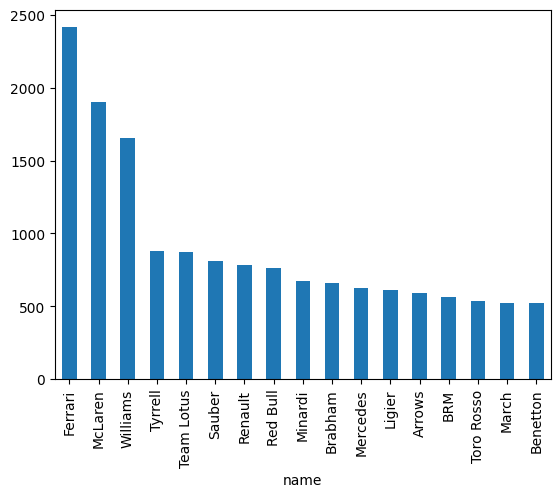

In [560]:
# Nombre de fois que les constructeurs sélectionnés apparaissent dans les données
df_selected_ecuries['name'].value_counts().plot(kind='bar')
plt.show()

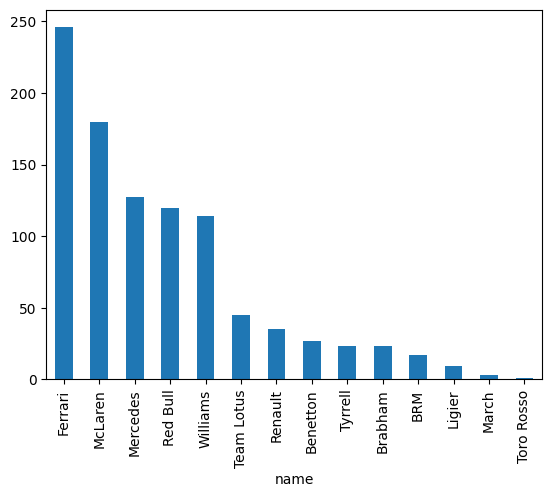

In [561]:
# Nombre de victoires par constructeur
df_selected_ecuries[df_selected_ecuries['positionOrder'] == 1]['name'].value_counts().plot(kind='bar')
plt.show()

### On remarque que certains constructeurs sont très performants, les victoires sont souvent pour les mêmes constructeurs.

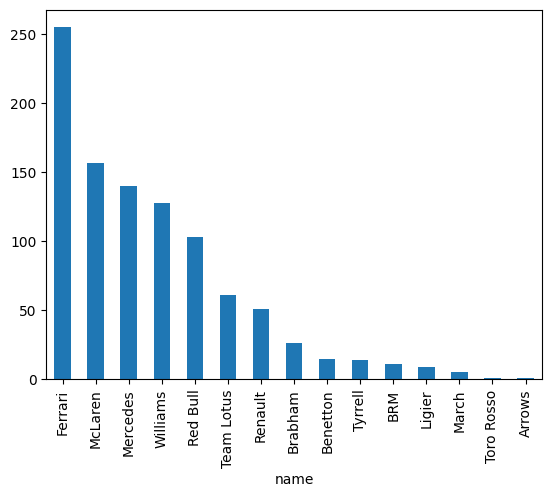

In [562]:
# Nombre de pole positions par constructeur
df_selected_ecuries[df_selected_ecuries['grid'] == 1]['name'].value_counts().plot(kind='bar')
plt.show()

### Pareil, c'est souvent les mêmes constructeurs qui ont la pole position.

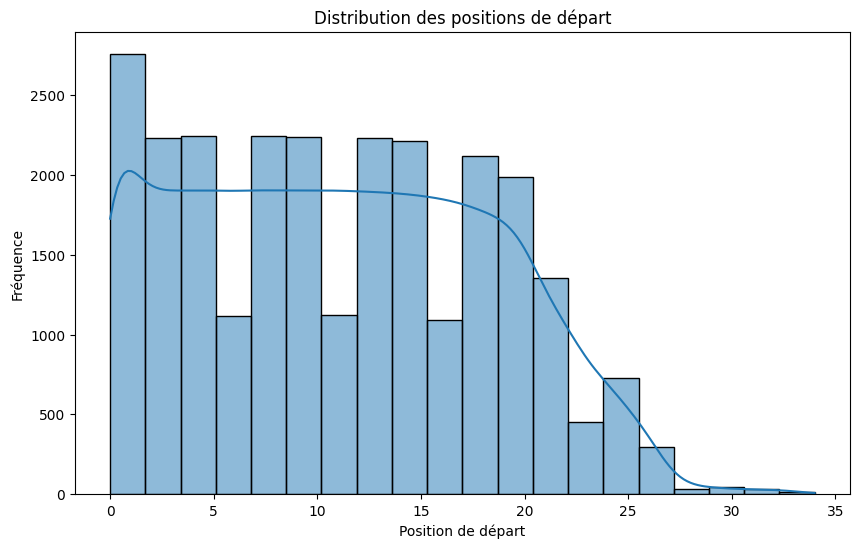

In [563]:
# Histogramme de la position de départ
plt.figure(figsize=(10,6))
sns.histplot(global_df['grid'], bins=20, kde=True)
plt.title("Distribution des positions de départ")
plt.xlabel("Position de départ")
plt.ylabel("Fréquence")
plt.show()

### Moins de données au delà de 25.... à voir dans la suite de l'analyse.

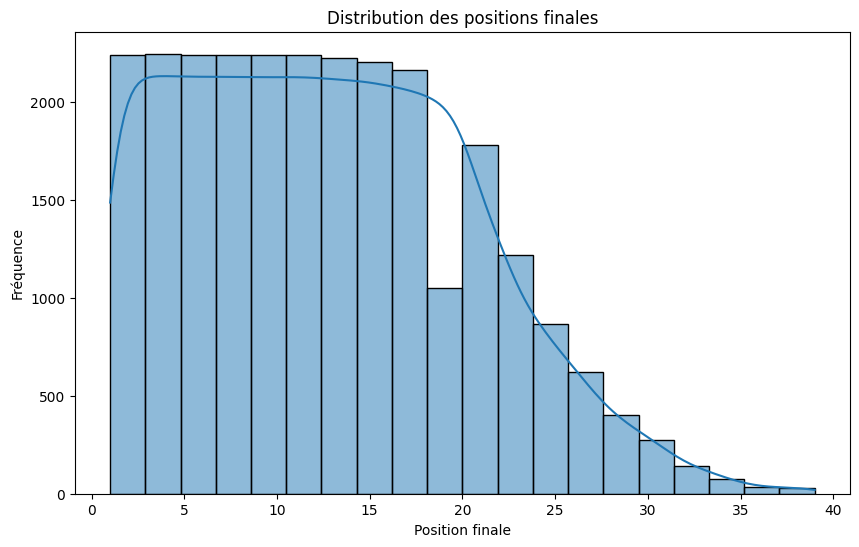

In [564]:
# Histogramme de la position finale
plt.figure(figsize=(10,6))
sns.histplot(global_df['positionOrder'], bins=20, kde=True)
plt.title("Distribution des positions finales")
plt.xlabel("Position finale")
plt.ylabel("Fréquence")
plt.show()

### Pareil, moins de données au delà de 25.... à voir dans la suite de l'analyse.

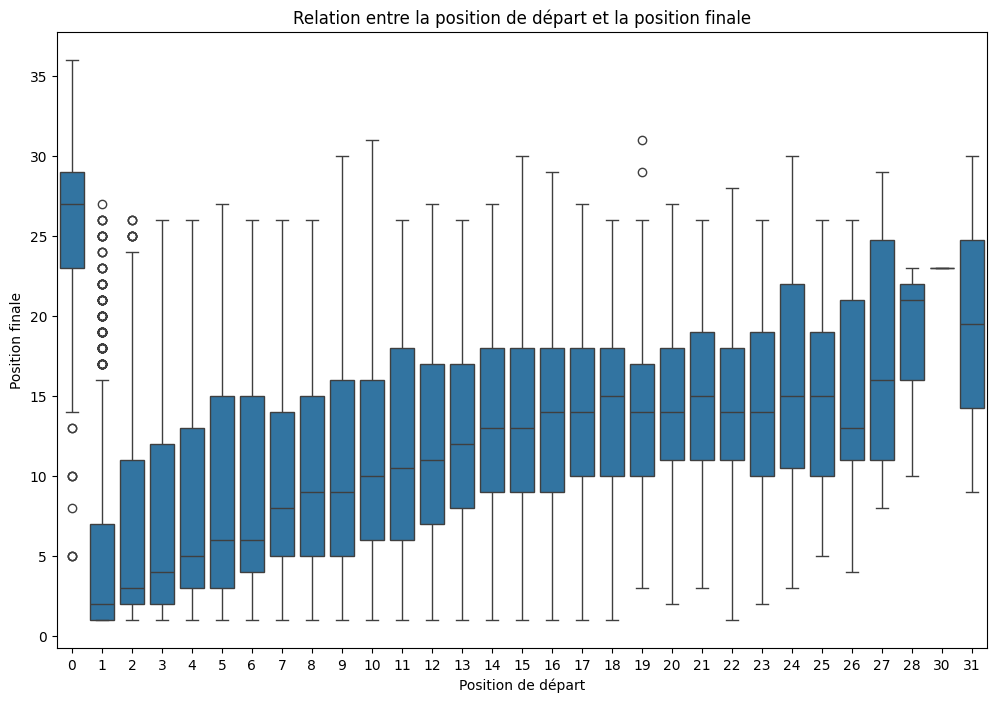

In [565]:
# Boxplot: Position de départ vs Position finale
plt.figure(figsize=(12,8))
sns.boxplot(x='grid', y='positionOrder', data=df_selected_ecuries)
plt.title("Relation entre la position de départ et la position finale")
plt.xlabel("Position de départ")
plt.ylabel("Position finale")
plt.show()

### On remarque ici que dans la colonne "grid", la valeur "0" semble être une valeur ""aberrante"", car il est impossible d'avoir une grille de départ à 0. Nous allons donc supprimer ces lignes.
(surrement une indication pour abandon ou autre)

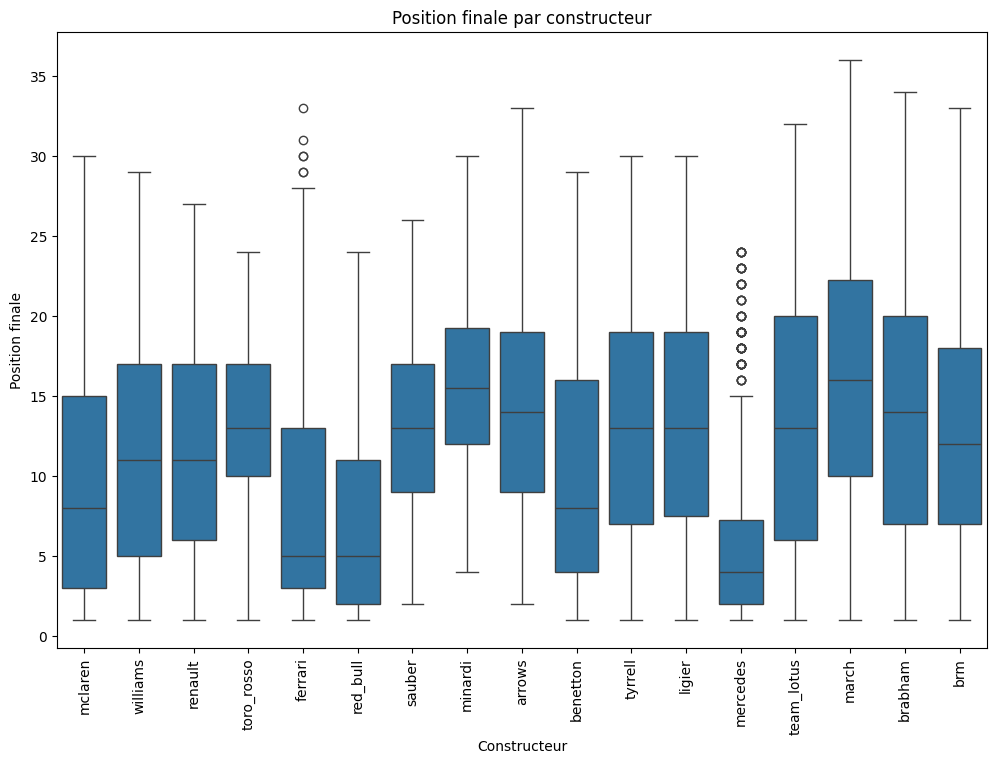

In [566]:
# Boxplot: Constructeur vs Position finale
plt.figure(figsize=(12,8))
sns.boxplot(x='constructorRef', y='positionOrder', data=df_selected_ecuries)
plt.title("Position finale par constructeur")
plt.xlabel("Constructeur")
plt.ylabel("Position finale")
plt.xticks(rotation=90)
plt.show()

### Ils sont tous en générale entre 1 et 20.... possible de supprimer les places au delà de 25 pour sûr ?

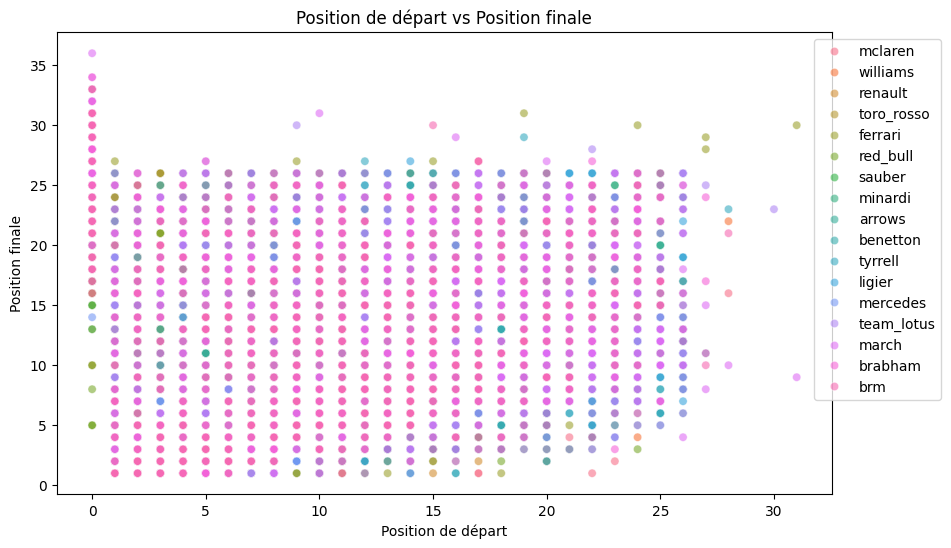

In [567]:
# Scatter plot: Position de départ vs Position finale
plt.figure(figsize=(10,6))
sns.scatterplot(x='grid', y='positionOrder', data=df_selected_ecuries, hue='constructorRef', alpha=0.6)
plt.title("Position de départ vs Position finale")
plt.xlabel("Position de départ")
plt.ylabel("Position finale")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

### C'est beau

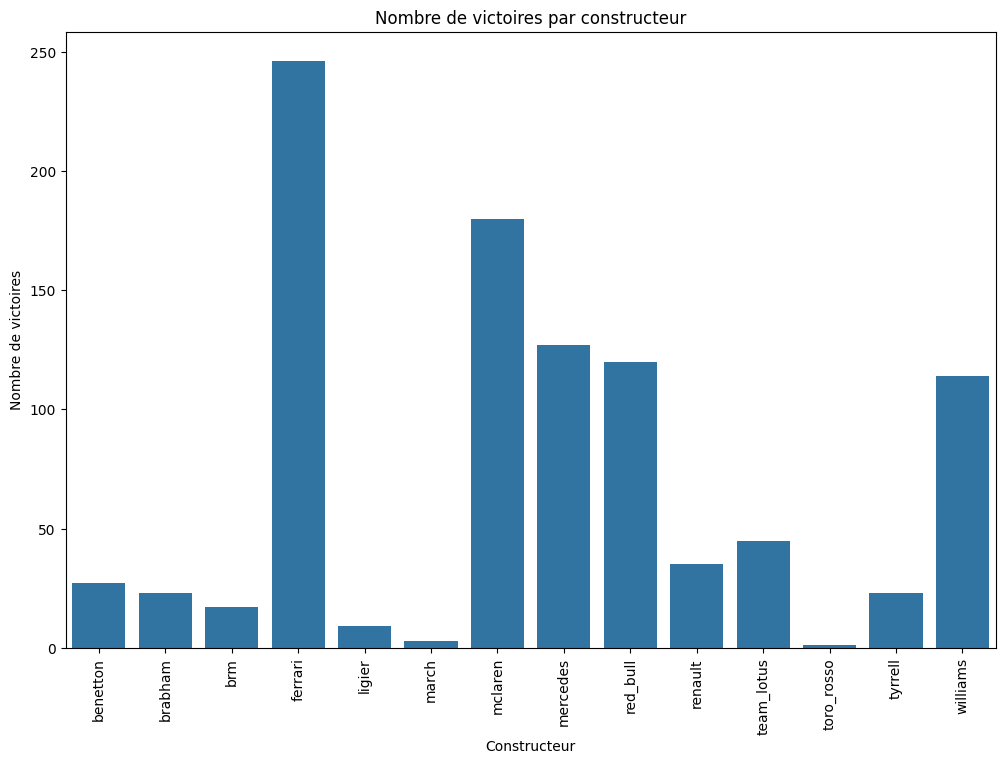

In [568]:
# Barplot: Nombre de victoires par constructeur
victory_df = df_selected_ecuries[df_selected_ecuries['positionOrder'] == 1]  # Filtre pour les victoires
victories_by_constructor = victory_df.groupby('constructorRef')['positionOrder'].count().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='constructorRef', y='positionOrder', data=victories_by_constructor)
plt.title("Nombre de victoires par constructeur")
plt.xlabel("Constructeur")
plt.ylabel("Nombre de victoires")
plt.xticks(rotation=90)
plt.show()

### Ferrari est fort

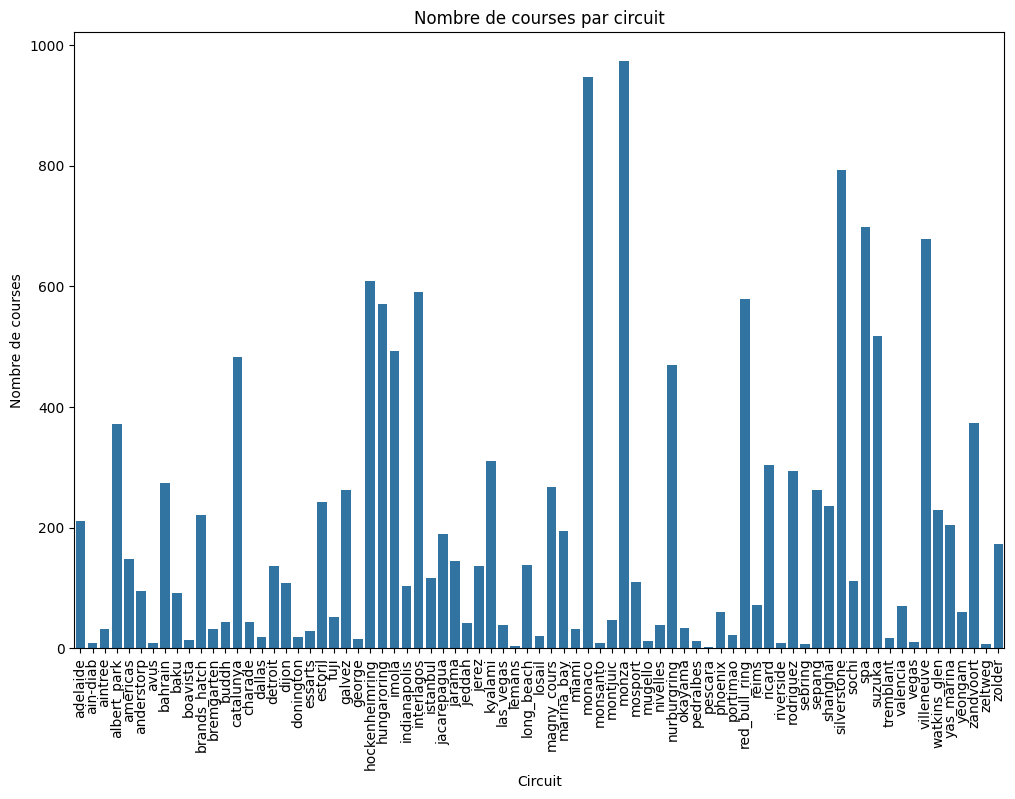

In [569]:
# Barplot: Répartition des courses par circuit
races_by_circuit = df_selected_ecuries.groupby('circuitRef')['raceId'].count().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='circuitRef', y='raceId', data=races_by_circuit)
plt.title("Nombre de courses par circuit")
plt.xlabel("Circuit")
plt.ylabel("Nombre de courses")
plt.xticks(rotation=90)
plt.show()

### On remarque que le nombre de lignes pour chaque circuit n'est pas le même, nous allons donc supprimer les circuits qui ont moins de 50 lignes de données.
Les circuits avec peu de données peuvent nous donner des résultats biaisés.

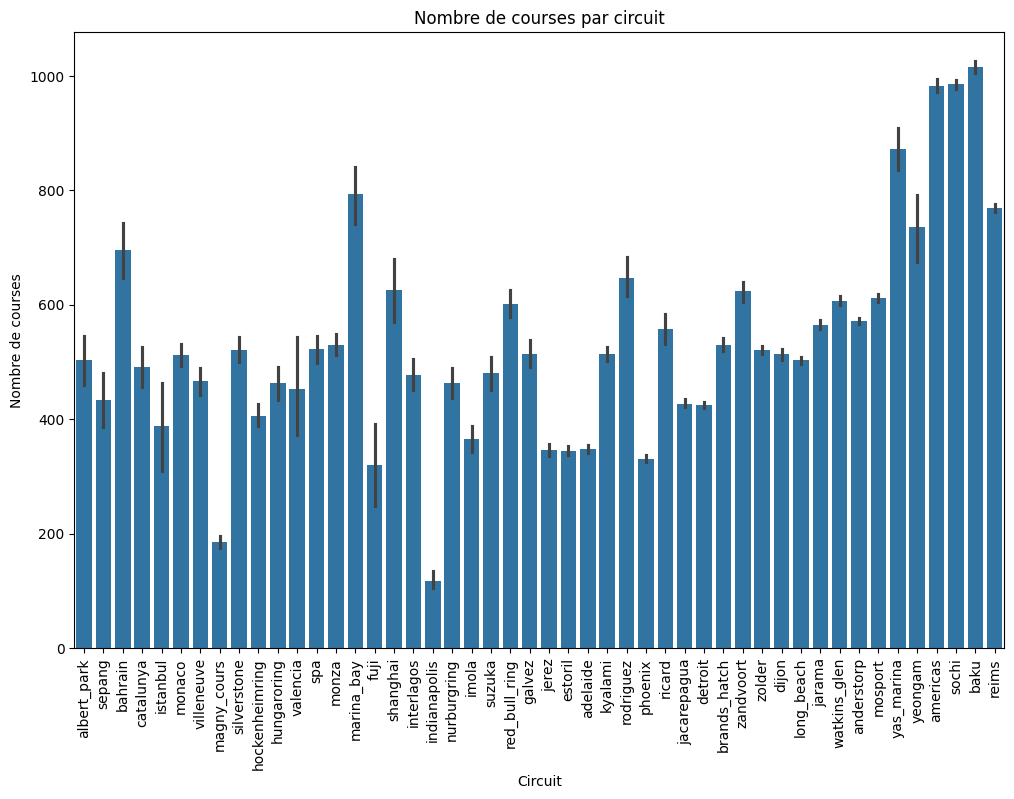

In [570]:
# Barplot: Répartition des courses par circuit
races_by_circuit = df_selected_ecuries.groupby('circuitRef')['raceId'].count().reset_index()

# Réduction du nombre de circuits pour n'afficher que ceux avec plus de 50 courses
races_by_circuit = df_selected_ecuries.groupby('circuitRef').filter(lambda x: len(x) > 50)

plt.figure(figsize=(12,8))
sns.barplot(x='circuitRef', y='raceId', data=races_by_circuit)
plt.title("Nombre de courses par circuit")
plt.xlabel("Circuit")
plt.ylabel("Nombre de courses")
plt.xticks(rotation=90)
plt.show()

# Réduction des données
Actuellement, il y a trop de colonnes (47), nous avons donc décidé de ne prendre en compte que les colonnes suivantes :
- grid : la position de départ du pilote
- positionOrder : la position d'arrivée du pilote
- circuitRef : le circuit de la course
- constructorRef : le constructeur de la F1
- year : l'année de la course

In [571]:
df_clean = df_selected_ecuries[["grid", "circuitRef", "constructorRef", "positionOrder", "year"]]
df_clean.shape

(15387, 5)

# Exclution des lignes avec une position de départ à 0 - considérées comme des abandons ou des disqualifications

In [572]:
df_final = df_clean[df_selected_ecuries['grid'] != 0]

In [573]:
df_final.shape

(14950, 5)

# Exclution des circuits avec moins de 50 lignes de données

In [574]:
course_counts = df_final['circuitRef'].value_counts()
courses_to_keep = course_counts[course_counts >= 100].index
df_final = df_final[df_final['circuitRef'].isin(courses_to_keep)]

In [575]:
df_final.shape

(13760, 5)

# Exclution des constructeurs avec moins de 500 lignes de données

In [576]:
constructor_counts = df_final['constructorRef'].value_counts()
constructors_to_keep = constructor_counts[constructor_counts >= 500].index
df_final = df_final[df_final['constructorRef'].isin(constructors_to_keep)]

In [577]:
df_final.shape

(12445, 5)

# Suppression des colonnes inutiles

In [578]:
df = df_final.drop_duplicates()

In [579]:
df.shape

(12419, 5)

In [580]:
# supprimer les lignes où la position de départ et finale sont supérieures à 25
df = df[(df['grid'] <= 25) & (df['positionOrder'] <= 25)]

In [581]:
df.shape

(12230, 5)

# Vérification des données pour voir s'il y a des valeurs manquantes

In [582]:
df.isnull().sum()

grid              0
circuitRef        0
constructorRef    0
positionOrder     0
year              0
dtype: int64

In [583]:
df_final.to_csv('df_final.csv', index=False)

# Réalisation des modèles de prédiction


In [584]:
# Encoder les colonnes 'circuitRef' et 'constructorRef'
label_encoder_circuit = LabelEncoder()
label_encoder_constructor = LabelEncoder()
label_encoder_year = LabelEncoder()

df['circuitRef'] = label_encoder_circuit.fit_transform(df['circuitRef'])
df['constructorRef'] = label_encoder_constructor.fit_transform(df['constructorRef'])
df['year'] = label_encoder_year.fit_transform(df['year'])

# Définir les features (X) et la cible (y)
X = df[['grid', 'circuitRef', 'constructorRef', 'year']]
y = df['positionOrder']

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RandomForestRegressor

In [585]:
# Création du modèle
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle
rf_model.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = rf_model.predict(X_test)

# Calcul du score et de l'erreur
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 6.479656212801749


## XGBoost

In [586]:
# Création du modèle XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entraînement du modèle
xgb_model.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = xgb_model.predict(X_test)

# Calcul du score et de l'erreur
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (XGBoost): {rmse}")

RMSE (XGBoost): 6.0736873052835945


## GradientBoostingRegressor

In [587]:
# Création du modèle Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entraînement du modèle
gb_model.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = gb_model.predict(X_test)

# Calcul du score et de l'erreur
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (Gradient Boosting): {rmse}")

RMSE (Gradient Boosting): 6.001527379194892


## LinearRegression

In [588]:
# Création du modèle de régression linéaire
linear_model = LinearRegression()

# Entraînement du modèle
linear_model.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = linear_model.predict(X_test)

# Calcul du RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (Linear Regression): {rmse}")

RMSE (Linear Regression): 6.158035738374329


## DecisionTreeRegressor

In [589]:
# Création du modèle d'arbre de décision
tree_model = DecisionTreeRegressor(random_state=42)

# Entraînement du modèle
tree_model.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = tree_model.predict(X_test)

# Calcul du RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (Decision Tree): {rmse}")

RMSE (Decision Tree): 8.81381066174162


In [590]:
# Création du dossier models et encoders
!mkdir models
!mkdir encoders

# Sauvegarder le modèle Gradient Boosting
joblib.dump(gb_model, 'models/gb_model.pkl')

# Sauvegarder le modèle XGBoost
joblib.dump(xgb_model, 'models/xgboost_model.pkl')

# Sauvegarder le modèle Linear Regression
joblib.dump(linear_model, 'models/linear_model.pkl')

# Sauvegarder les encoders (pour le chargement des strings)
joblib.dump(label_encoder_circuit, 'encoders/label_encoder_circuit.pkl')
joblib.dump(label_encoder_constructor, 'encoders/label_encoder_constructor.pkl')
joblib.dump(label_encoder_year, 'encoders/label_encoder_year.pkl')

Un sous-r�pertoire ou un fichier models existe d�j�.
Un sous-r�pertoire ou un fichier encoders existe d�j�.


['encoders/label_encoder_year.pkl']

In [591]:
# Chargement des modèles et des encoders
rf_model = joblib.load('models/gb_model.pkl')
label_encoder_circuit = joblib.load('encoders/label_encoder_circuit.pkl')
label_encoder_constructor = joblib.load('encoders/label_encoder_constructor.pkl')
label_encoder_year = joblib.load('encoders/label_encoder_year.pkl')

# Nouvelle entrée
new_data = {
    'grid': 5,
    'circuitRef': 'bahrain',
    'constructorRef': 'red_bull',
    'year': 2024
}

# Transformer les strings en catégories avec les encoders
new_data['circuitRef'] = label_encoder_circuit.transform([new_data['circuitRef']])[0]
new_data['constructorRef'] = label_encoder_constructor.transform([new_data['constructorRef']])[0]
new_data['year'] = label_encoder_year.transform([new_data['year']])[0]

# Créer un DataFrame pour la prédiction
new_data_df = pd.DataFrame([new_data])

# Prédire la position finale
predicted_position = rf_model.predict(new_data_df)
print(f"Position finale prédite : {predicted_position[0].round(0)}")

Position finale prédite : 6.0
